# Intro Task, Object Localization 

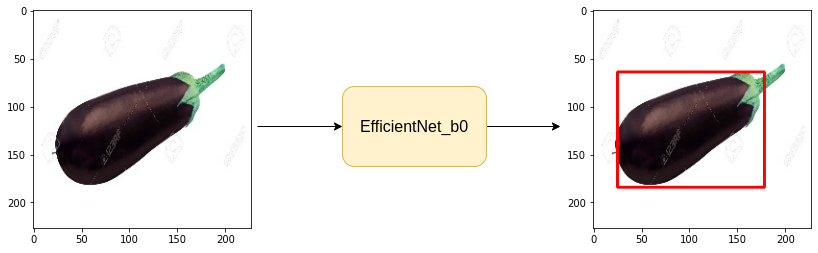

In [ ]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-lzcx8h8f
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-lzcx8h8f
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR =  '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR= 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head(10)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

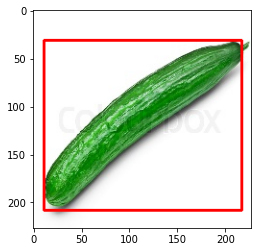

In [ ]:
row = df.iloc[182]

img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1=(row.xmin, row.ymin)
pt2= (row.xmax,row.ymax)
bnd_box_img = cv2.rectangle(img, pt1,pt2,(255,0,0), 2)
plt.imshow(bnd_box_img)

In [ ]:
train_df,valid_df = train_test_split(df,test_size = .20, random_state = 42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjectLocDataset(torch.utils.data.Dataset):
  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return  len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    xmin= row.xmin
    ymin= row.ymin
    xmax= row.xmax
    ymax= row.ymax

    bbox = [[xmin,ymin,xmax,ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]
    
    img = torch.from_numpy(img).permute(2,0,1)/255.0
    bbox= torch.Tensor(bbox)
    return img,bbox


In [ ]:
trainset = ObjectLocDataset(train_df,train_augs)
validset = ObjectLocDataset(valid_df,valid_augs)

In [ ]:
print(f"Total Examples in trainset : {len(trainset)}")
print(f"Total Examples in validset : {len(validset)}")

Total Examples in trainset : 148
Total Examples in validset : 38


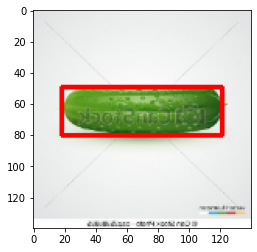

In [ ]:
img, bbox = trainset[10]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle= True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle= False)


In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images,bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn 
import timm

In [ ]:
class ObjLocModel(nn.Module):

  def __init__(self):
      super(ObjLocModel,self).__init__()

      self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

  def forward(self, images, gt_bboxes = None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes,loss
    
    return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE);

In [ ]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):

    images, gt_bboxes = data 
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxex,loss = model(images,gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()

  with torch.no_grad():
    for data in tqdm(dataloader):

      images, gt_bboxes = data 
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxex,loss = model(images,gt_bboxes)
      total_loss += loss.item()
    
  return total_loss / len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr= LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("Weights are saved")
    best_valid_loss = valid_loss
  
  print(f"Epoch : {i+1} train loss : {train_loss} valid loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 1 train loss : 5142.847241210938 valid loss : 3667.647216796875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 2 train loss : 2169.490625 valid loss : 799.9299723307291


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 3 train loss : 1232.0718994140625 valid loss : 217.66906229654947


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 4 train loss : 819.05029296875 valid loss : 209.311279296875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 5 train loss : 683.5140625 valid loss : 203.95267232259116


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 train loss : 491.652587890625 valid loss : 205.97164916992188


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 train loss : 360.6284713745117 valid loss : 305.06504313151044


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 8 train loss : 250.20942230224608 valid loss : 160.16223907470703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 9 train loss : 250.328173828125 valid loss : 142.54071553548178


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 10 train loss : 188.7417350769043 valid loss : 126.22472890218098


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 11 train loss : 149.76507568359375 valid loss : 123.25281778971355


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 12 train loss : 121.95893249511718 valid loss : 97.7426249186198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 13 train loss : 118.0179946899414 valid loss : 81.26379140218098


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14 train loss : 103.23489303588867 valid loss : 136.75027974446616


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15 train loss : 92.04374809265137 valid loss : 119.39169565836589


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 train loss : 83.40096855163574 valid loss : 90.8295669555664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss : 83.5185432434082 valid loss : 94.33363342285156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 18 train loss : 73.33877410888672 valid loss : 73.88326644897461


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19 train loss : 79.07369270324708 valid loss : 85.07627868652344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 train loss : 55.44272117614746 valid loss : 106.5606180826823


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 train loss : 61.454484939575195 valid loss : 83.29894765218098


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 22 train loss : 52.500980377197266 valid loss : 66.48759206136067


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 23 train loss : 46.83328800201416 valid loss : 54.53442891438802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 24 train loss : 51.07123432159424 valid loss : 51.29500071207682


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss : 43.201372146606445 valid loss : 81.85339609781902


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26 train loss : 42.57255249023437 valid loss : 55.61776351928711


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 27 train loss : 47.65526351928711 valid loss : 43.85478973388672


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 train loss : 72.92973976135254 valid loss : 67.98496882120769


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 29 train loss : 51.90148239135742 valid loss : 43.722574869791664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 train loss : 66.98183631896973 valid loss : 78.21378962198894


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss : 45.93609046936035 valid loss : 60.52271016438802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss : 46.778146743774414 valid loss : 83.5928560892741


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 train loss : 56.635987281799316 valid loss : 85.60576502482097


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss : 46.19539108276367 valid loss : 75.08321634928386


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 train loss : 41.255849838256836 valid loss : 67.58123588562012


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss : 40.00660438537598 valid loss : 60.169359842936196


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 train loss : 34.86181306838989 valid loss : 63.82146962483724


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss : 45.070559692382815 valid loss : 79.29641215006511


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 train loss : 36.28313503265381 valid loss : 48.7588259379069


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 train loss : 44.24296646118164 valid loss : 55.153724670410156


#Inference

In [ ]:
import utils

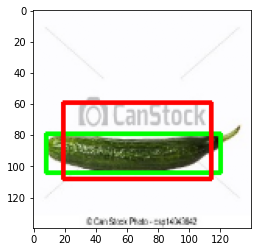

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

  image,gt_bbox = validset[18]
  image = image.unsqueeze(0).to(DEVICE)
  out_bbox = model(image)

  utils.compare_plots(image,gt_bbox, out_bbox)


Linkedin : www.linkedin.com/in/KaziTanvir
Github : https://github.com/KaziTanvir